In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from IPython.display import Image, display
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import OrdinalEncoder

In [2]:
train_df = pd.read_csv('/content/train.csv')
transactions_df = pd.read_csv('/content/transactions.csv')
stores_df = pd.read_csv('/content/stores.csv')

train_df = pd.merge(train_df,stores_df,how='left',on='store_nbr')
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [3]:
oil_df = pd.read_csv('/content/oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])

oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [4]:
print(len(train_df.date.unique()) , len(oil_df.date.unique()))

dates_df = pd.DataFrame(train_df.date.unique(), columns=['date'])
dates_df['date'] = pd.to_datetime(dates_df['date'], errors='coerce')
dates_df = dates_df.dropna()  # drop rows with missing dates

oil_df = pd.merge(dates_df, oil_df, how="left", on="date")
oil_df = oil_df.set_index('date')
oil_df.shape

1684 1218


(1684, 1)

In [5]:
print(oil_df.query('dcoilwtico != dcoilwtico'))
print(oil_df.isnull().sum())
print(oil_df.describe())

            dcoilwtico
date                  
2013-01-01         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-12         NaN
2013-01-13         NaN
...                ...
2017-07-30         NaN
2017-08-05         NaN
2017-08-06         NaN
2017-08-12         NaN
2017-08-13         NaN

[521 rows x 1 columns]
dcoilwtico    521
dtype: int64
        dcoilwtico
count  1163.000000
mean     67.925589
std      25.677366
min      26.190000
25%      46.390000
50%      53.330000
75%      95.790000
max     110.620000


In [6]:
import plotly.express as px

fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)
fig.show()

In [7]:
oil_na = oil_df.copy()
oil_na.dropna()

,dcoilwtico
date,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21
...,...
2017-08-09,49.59
2017-08-10,48.54
2017-08-11,48.81


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

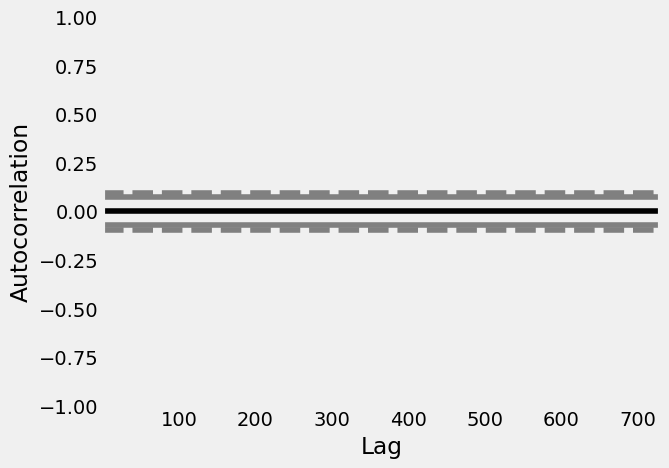

In [8]:
pd.plotting.autocorrelation_plot(oil_na['2015':'2016']['dcoilwtico'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

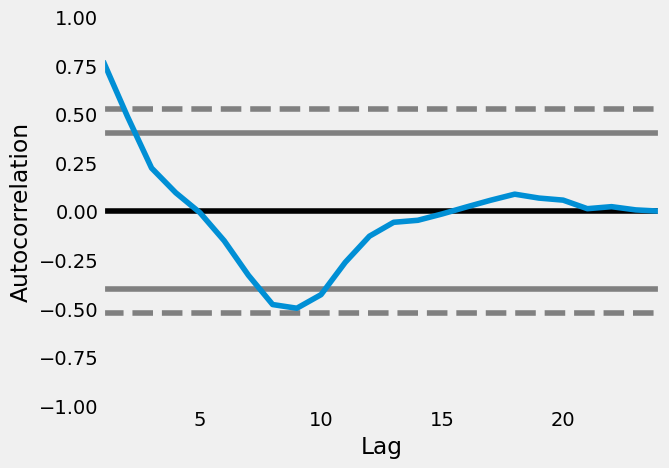

In [9]:
pd.plotting.autocorrelation_plot(oil_df['2015':'2016']['dcoilwtico'].resample('1m').mean())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

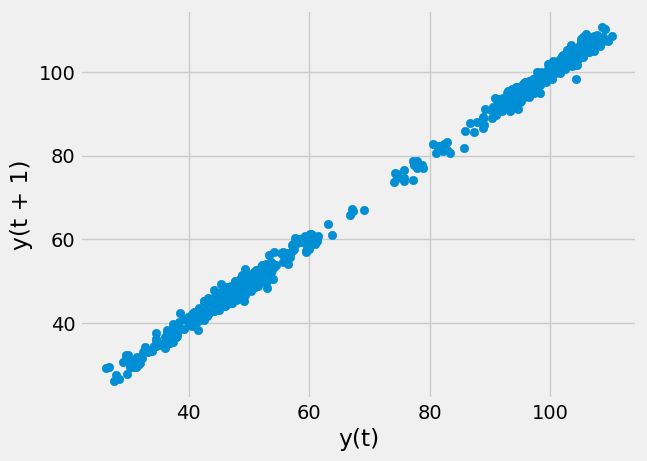

In [10]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 1)

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

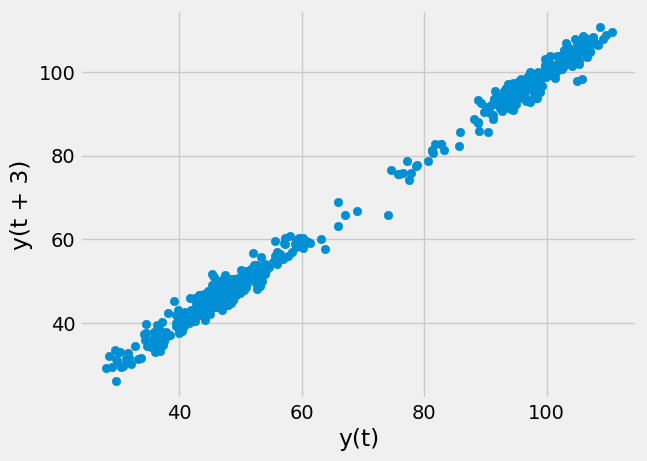

In [11]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 3)

<Axes: xlabel='y(t)', ylabel='y(t + 30)'>

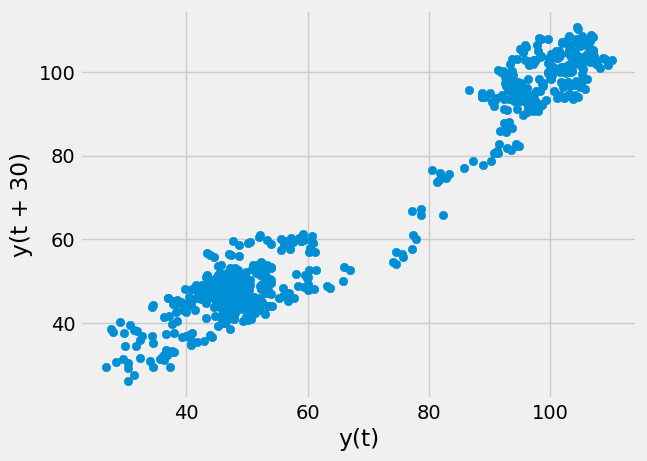

In [12]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 30)

In [13]:
oil_df['dcoilwtico'][0] = oil_df['dcoilwtico'][1].copy()
oil_df = oil_df.interpolate(method='linear')

In [14]:
fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)

In [15]:
train_df['date'] = pd.to_datetime(train_df['date'], errors="coerce")
train_df=train_df.dropna()
train_df = train_df.set_index('date')

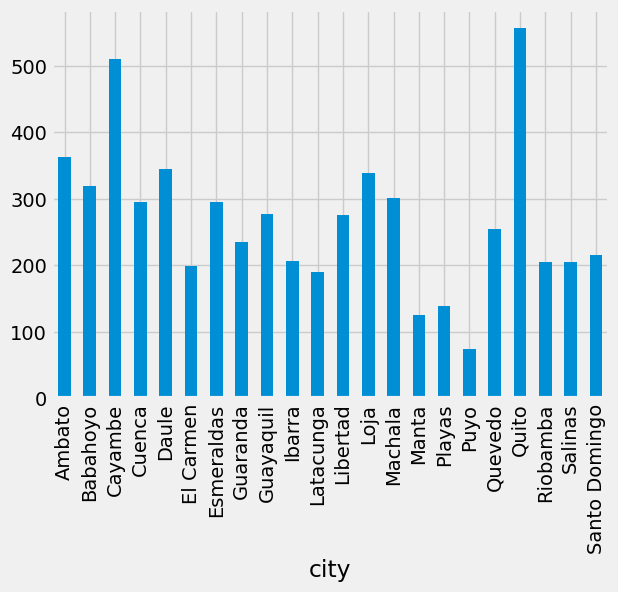

In [16]:
train_df.groupby(['city']).sales.mean().plot(kind='bar');

Text(0.5, 1.0, 'Promotion and Sales Relationship')

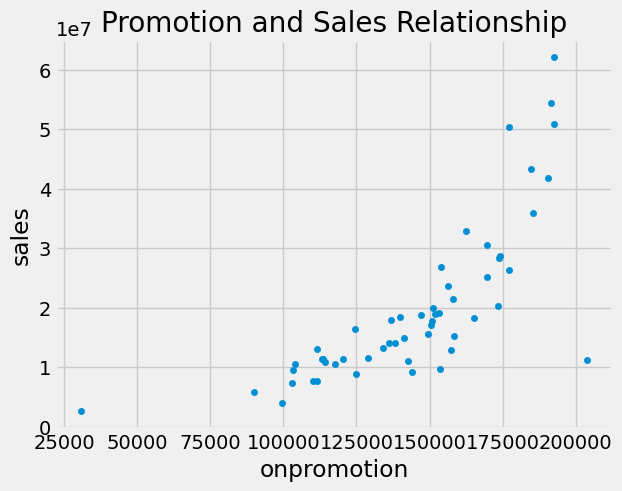

In [17]:
train_df.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales')
plt.title('Promotion and Sales Relationship')

In [18]:
train_df = pd.merge(train_df,oil_df,how='left',on='date')

In [19]:
print(train_df.query('dcoilwtico !=dcoilwtico'))

Empty DataFrame
Columns: [id, store_nbr, family, sales, onpromotion, city, state, type, cluster, dcoilwtico]
Index: []


In [20]:
grouped = train_df.groupby(['date']).agg({'dcoilwtico': 'mean', 'sales': 'mean'})
fig = px.line(grouped, x=grouped.index , y=['sales', 'dcoilwtico'])
fig.update_layout(title='Sale and Date Plot')
fig.show()
del grouped

In [21]:
train_df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
date,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


In [22]:
holidays_df = pd.read_csv('/content/holidays_events.csv')

holidays_df = holidays_df[holidays_df['transferred'] == False].copy()
holidays_df['holiday_type'] = holidays_df['type']
holidays_df.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
national_holidays['national_holiday_type'] = national_holidays['holiday_type']
national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
national_holidays['date'] = pd.to_datetime(national_holidays['date'])
train_df = pd.merge(train_df, national_holidays, how='left', on=['date'])
state_holidays = holidays_df[holidays_df['locale'] == 'Regional'].copy()
state_holidays['state'] = state_holidays['locale_name']
state_holidays['state_holiday_type'] = state_holidays['holiday_type']
state_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
state_holidays['date'] = pd.to_datetime(state_holidays['date'])
train_df = pd.merge(train_df, state_holidays, how='left', on=['date', 'state'])

city_holidays = holidays_df[holidays_df['locale'] == 'Local'].copy()
city_holidays['city'] = city_holidays['locale_name']
city_holidays['city_holiday_type'] = city_holidays['holiday_type']
city_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
city_holidays.drop([265], axis=0, inplace=True)
city_holidays['date'] = pd.to_datetime(city_holidays['date'])
train_df = pd.merge(train_df, city_holidays, how='left', on=['date', 'city'])

del city_holidays
del state_holidays
del national_holidays

train_df.head()


,date,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,national_holiday_type,state_holiday_type,city_holiday_type
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
1,2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
2,2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
3,2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
4,2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN


In [23]:
train_df.fillna('', inplace=True)

In [24]:
ordinal_encoder = OrdinalEncoder(dtype=int)
train_df[['family']] = ordinal_encoder.fit_transform(train_df[['family']])
train_df[['national_holiday_type']] = ordinal_encoder.fit_transform(train_df[['national_holiday_type']])
train_df[['state_holiday_type']] = ordinal_encoder.fit_transform(train_df[['state_holiday_type']])
train_df[['city_holiday_type']] = ordinal_encoder.fit_transform(train_df[['city_holiday_type']])


In [25]:
del train_df['city']
del train_df['state']
del train_df['type']
train_df.head()

,date,id,store_nbr,family,sales,onpromotion,cluster,dcoilwtico,national_holiday_type,state_holiday_type,city_holiday_type
0,2013-01-01,0,1,0,0.0,0,13,93.14,4,0,0
1,2013-01-01,1,1,1,0.0,0,13,93.14,4,0,0
2,2013-01-01,2,1,2,0.0,0,13,93.14,4,0,0
3,2013-01-01,3,1,3,0.0,0,13,93.14,4,0,0
4,2013-01-01,4,1,4,0.0,0,13,93.14,4,0,0


<ipython-input-26-c79fd6c2bc40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

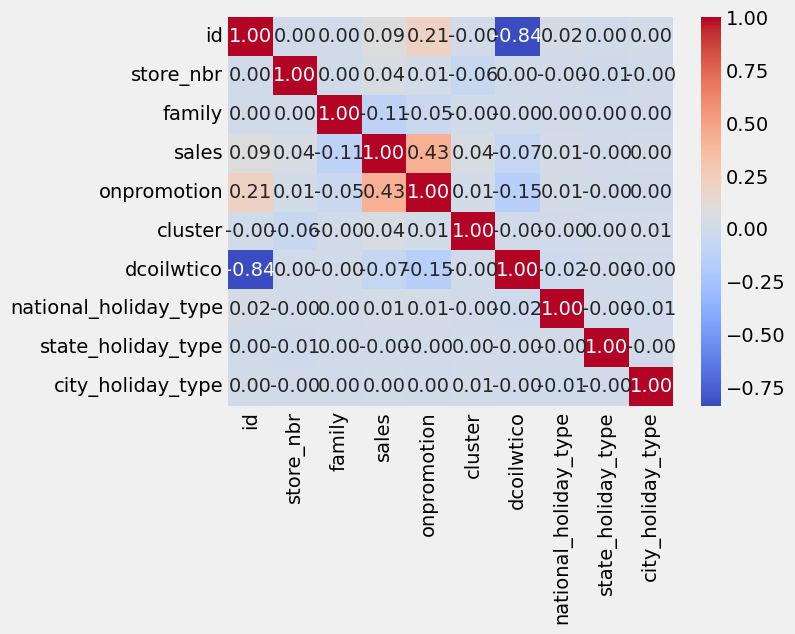

In [26]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = train_df.corr()

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [27]:
grouped_df = train_df.groupby(['date']).agg({'sales': 'sum','dcoilwtico': 'mean', 
                                                 'onpromotion': 'sum',
                                                 'national_holiday_type': 'mean',
                                                 'city_holiday_type': 'mean',
                                                 'state_holiday_type': 'mean'})

grouped_df.head()

,sales,dcoilwtico,onpromotion,national_holiday_type,city_holiday_type,state_holiday_type
date,,,,,,
2013-01-01,2511.618999,93.140000,0,4.0,0.0,0.0
2013-01-02,496092.417944,93.140000,0,0.0,0.0,0.0
2013-01-03,361461.231124,92.970000,0,0.0,0.0,0.0
2013-01-04,354459.677093,93.120000,0,0.0,0.0,0.0
2013-01-05,477350.121229,93.146667,0,6.0,0.0,0.0


In [28]:
scaler  = MinMaxScaler()
scaled_grouped_df = scaler.fit_transform(grouped_df)
scaled_grouped_df.shape

(1684, 6)

In [29]:
features = scaled_grouped_df
target = scaled_grouped_df[:,0]

features.shape

(1684, 6)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state= 4, shuffle= False)

In [31]:
win_length = 50
batch_size = 32
input_features = 12

train_generator = TimeseriesGenerator(X_train, y_train, length =win_length,
                    sampling_rate =1, batch_size =batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length =win_length,
                    sampling_rate =1, batch_size =batch_size)

In [32]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True,input_shape=[win_length, input_features]))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           72192     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           131584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 50, 128)           0         
                                                                 
 dropout (Dropout)           (None, 50, 128)           0

In [33]:
model.compile(loss= tf.losses.MeanSquaredError(),
             optimizer= tf.optimizers.Adam(),
             metrics =[tf.metrics.MeanAbsoluteError()])


history = model.fit(train_generator, epochs =100,
                              validation_data= test_generator,
                              shuffle = False)

Epoch 1/100
46/46 [==============================] - 16s 59ms/step - loss: 0.0238 - mean_absolute_error: 0.1232 - val_loss: 0.0209 - val_mean_absolute_error: 0.1279
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0315 - mean_absolute_error: 0.1381 - val_loss: 0.0172 - val_mean_absolute_error: 0.1161
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0358 - mean_absolute_error: 0.1467 - val_loss: 0.0136 - val_mean_absolute_error: 0.1003
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0291 - mean_absolute_error: 0.1319 - val_loss: 0.0153 - val_mean_absolute_error: 0.0873
Epoch 5/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0294 - mean_absolute_error: 0.1366 - val_loss: 0.0153 - val_mean_absolute_error: 0.0873
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0275 - mean_absolute_error: 0.1321 - val_loss: 0.0132 - val_mean_absolute_error: 0.0897
Epoch 7/100
46/

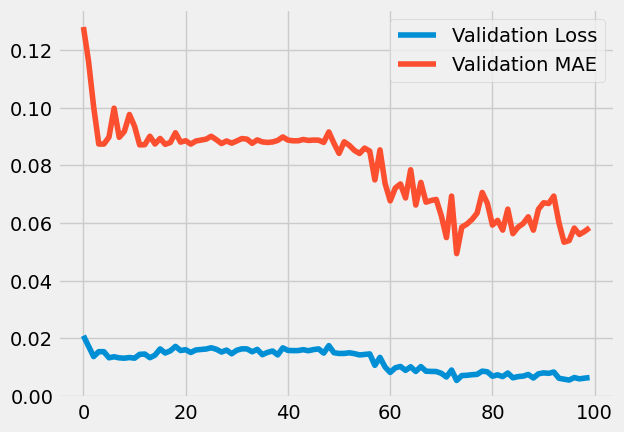

In [34]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

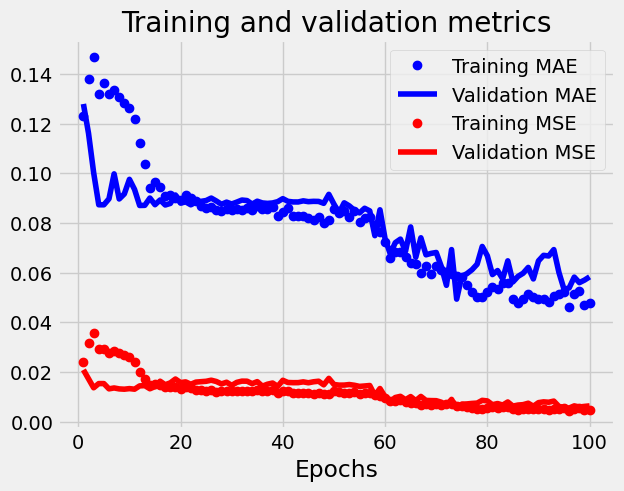

In [35]:


mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['loss']
val_mse = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.plot(epochs, mse, 'ro', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.legend()
plt.show()


In [36]:
test_metrics = model.evaluate(test_generator, verbose=0)
test_mse = test_metrics[0]
test_mae = test_metrics[1]
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test MSE: 0.0063
Test MAE: 0.0583


In [37]:
predictions = model.predict(test_generator)

4/4 [==============================] - 1s 8ms/step


In [38]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)

In [39]:
df_final = grouped_df[predictions.shape[0]*-1:].copy()

In [40]:
df_final.count()

sales                    119
dcoilwtico               119
onpromotion              119
national_holiday_type    119
city_holiday_type        119
state_holiday_type       119
dtype: int64

In [41]:
df_final['predictions'] = rev_trans[:,0]

<Axes: xlabel='date'>

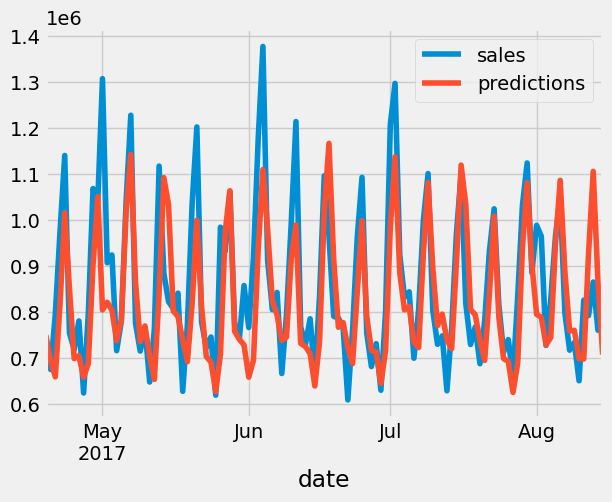

In [42]:
df_final[['sales','predictions']].plot()